# 2. Writing Calclation tools

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
%matplotlib inline

# step 1: calculating net forces vectors function

def getForce(mi, mj, sep):
    """
    Compute magnitude of gravitational force between two bodies.
    
    Parameters
    ----------
    mi, mj : float
        Particle masses in kg.
    sep : float
        Particle separation (distance between bodies) in m.
        
    Returns
    -------
    force : float
        Gravitational force between bodies in N.
    
    Example
    -------
    >>> # appx. force between Earth and 70 kg person on surface
    >>> mEarth = 6e24
    >>> mPerson = 70
    >>> radiusEarth = 6380000 
    >>> getForce(mEarth, mPerson, radiusEarth)
    688.2302650327729
    """
    G = 6.67e-11                # m3 kg-1 s-2
    return G * mi * mj / sep**2 # N

def magnitude(vec):
    """
    Compute magnitude of any vector with an arbitrary number of elements.
    """
    return np.sqrt(np.sum(vec**2))

def unitVec(vec):
    """
    Create unit vector from a vector with any number of elements.
    """
    # divide vector components by vector magnitude to make unit vector
    mag = magnitude(vec)
    return vec/mag

def getSepVec(pos_i, pos_j):
    """
    Compute separation vector from i to j.
    
    Parameters
    ----------
    pos_i, pos_j : numpy arrays
        Particle positions as 3-element arrays [x, y, z].
        Note that as written, the code on N-D arrays.
        
    Returns
    -------
    sepVec : numpy array
        Separation vector, also as a 3-element array.
        
    Example
    -------
    >>> getSepVec(np.array([-1, -2, -3]), np.array([1, 2, 3])
    [2, 4, 6]
    
    """
    
    # subtract components to get separation vector
    return pos_j - pos_i

def getForceVec(mi, mj, pos_i, pos_j):
    """
    Compute gravitational force vector exerted on particle i by particle j.
    
    Parameters
    ----------
    mi, mj : float
        Particle masses in kg.
    pos_i, pos_j : numpy arrays
        Particle positions in cartesian coordinates in m.
        
    Returns
    -------
    forceVec : list
        Components of gravitational force vector in N.
        
    Example
    -------
    >>> getForceVec(1e10, 1e10, [0, 0, 0], [1, 1, 1])
    [1283.6420984982683, 1283.6420984982683, 1283.6420984982683]
    
    """
    
    # compute magnitude of the force
    sepvec = getSepVec(pos_i, pos_j)            # [m]
    force = getForce(mi, mj, magnitude(sepvec)) # [N]
    
    # get the components of a unit vector in the
    # force direction
    unit_sepvec = unitVec(sepvec)
    
    # return the force as a vector
    return force*unit_sepvec # [N]

def netForces(masses, positions):
    '''
    Calculates the net force vector / array for each mass in a given list of masses at their respective positions
    
    Parameters
    ----------
    masses, positions:
    
    masses is a list of masses
    positions is an array of position vectors for each mass
    
    
    Returns
    -------
    forces:
    
    forces is a list that contains a net force vector for each mass provided in the list of masses
    
    Example
    -------
    >>> netForces(masses, positions)
    [[-1.27997846e+15  3.76058130e+14  3.48003398e+14]
     [ 9.21848648e+15 -5.29940549e+16  1.77381163e+15]
     [ 7.46401064e+16  5.37755035e+16 -2.70829085e+16]
     [-4.24480469e+16  6.37685810e+15  1.09538370e+15]
     [-4.01305675e+16 -7.53436488e+15  2.38657098e+16]] 
    '''
    listOfForces=[]
    for i in range(len(masses)):
        netforce = np.zeros(3)
        for j in range(len(masses)):
            if i != j:
                force = getForceVec(masses[i], masses[j], positions[i], positions[j])
                netforce += force
        listOfForces.append(netforce)
    forces = np.array(listOfForces)
    return forces

In [2]:
# lets test the force function with something we know the answer to: 
# we know that two masses of mass 1 kg each, displaced by 1 meter, should feel net forces of +/- G

test_masses = np.array([[1],[1]])
test_positions = np.array([[0,0,0],[1,0,0]])

test_force = netForces(test_masses, test_positions)
print(test_force)

[[ 6.67e-11  0.00e+00  0.00e+00]
 [-6.67e-11  0.00e+00  0.00e+00]]


In [3]:
# step 2: copy in the one step leapfrog function

def updateParticles(masses, positions, velocities, dt):
    """
    Evolve particles in time via leap-frog integrator scheme. This function
    takes masses, positions, velocities, and a time step dt as

    Parameters
    ----------
    masses : np.ndarray
        1-D array containing masses for all particles, in kg
        It has length N, where N is the number of particles.
    positions : np.ndarray
        2-D array containing (x, y, z) positions for all particles.
        Shape is (N, 3) where N is the number of particles.
    velocities : np.ndarray
        2-D array containing (x, y, z) velocities for all particles.
        Shape is (N, 3) where N is the number of particles.
    dt : float
        Evolve system for time dt (in seconds).

    Returns
    -------
    Updated particle positions and particle velocities, each being a 2-D
    array with shape (N, 3), where N is the number of particles.

    """

    startingPositions = np.array(positions)
    startingVelocities = np.array(velocities)

    # how many particles are there?
    nParticles, nDimensions = startingPositions.shape

    # make sure the three input arrays have consistent shapes
    assert(startingVelocities.shape == startingPositions.shape)
    assert(len(masses) == nParticles)

    # calculate net force vectors on all particles, at the starting position
    startingForces = np.array(netForces(masses, startingPositions))

    # calculate the acceleration due to gravity, at the starting position
    startingAccelerations = startingForces/np.array(masses).reshape(nParticles, 1)

    # calculate the ending position
    nudge = startingVelocities*dt + 0.5*startingAccelerations*dt**2
    endingPositions = startingPositions + nudge

    # calculate net force vectors on all particles, at the ending position
    endingForces = np.array(netForces(masses, endingPositions))

    # calculate the acceleration due to gravity, at the ending position
    endingAccelerations = endingForces/np.array(masses).reshape(nParticles, 1)

    # calculate the ending velocity
    endingVelocities = (startingVelocities +
                        0.5*(endingAccelerations + startingAccelerations)*dt)

    return endingPositions, endingVelocities

In [4]:
# write a function to run updateParticles over n_times on a system to calculate its change in position and velocity as a function of time
def calculateTrajectories(masses, positions, velocities, time_running, dt):
    """
    Evolves particles initial postions and velocities throughout time
    
    Parameters
    ----------
    masses : np.ndarray
        1-D array containing masses for all particles, in kg
        It has length N, where N is the number of particles.
    positions : np.ndarray
        2-D array containing (x, y, z) positions for all particles.
        Shape is (N, 3) where N is the number of particles.
    velocities : np.ndarray
        2-D array containing (x, y, z) velocities for all particles.
        Shape is (N, 3) where N is the number of particles.
    time_running: float
        The total recorded time the system evolves for (in seconds)
    dt : float
        A time increment (in seconds).

    Returns
    -------
    Three arrays: A time array (showing each time recorded), 
    updated particle positions and particle velocities, each being a 2-D
    array with shape (N, 3), where N is the number of particles.
    """
    n_times = int(time_running / dt)
    times = np.linspace(0,time_running,n_times+1)
    new_positions = [positions]
    new_velocities = [velocities]
    for i in range(n_times):
        next_step = updateParticles(masses, positions, velocities, dt)
        new_positions.append(next_step[0])
        new_velocities.append(next_step[1])
        positions = next_step[0]
        velocities = next_step[1]
    new_positions = np.array(new_positions)
    new_velocities = np.array(new_velocities)
    return times, new_positions, new_velocities

# 3. Earth orbiting Sun

In [5]:
# step 1: write out the masses, initial positions and velocities then run the calculateTrajectories function on them

sec = 86400 #variable to convert days to seconds or vice versa
au = 1.496e11 #variable to convert au to meters or vice versa

# redefine the following variables with all the same inputs as before except 1/2 the velocity
sun_earth_masses = np.array([1.989e30,5.972e24])
sun_earth_positions = np.array([[-3e-6,     0 , 0],
                                [0.9999997, 0 , 0]])*au
sun_earth_velocities = np.array([[0, -8.92e-2, 0],
                                 [0,  2.98e4 , 0]])
time_passed = 1000. * sec #time the system evolves in seconds
dt = 0.1 * sec #the time increment in seconds

# run the calculateTrajectories function on the sun earth system, then unpack the outputs
sun_earth = calculateTrajectories(sun_earth_masses, sun_earth_positions, sun_earth_velocities, time_passed, dt)
sun_earth_times, sun_earth_positions, sun_earth_velocities = sun_earth

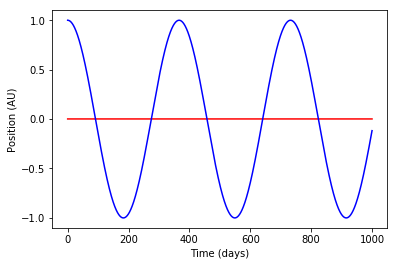

In [6]:
# step 2: three plots summarizing the results

# first plot: time passes vs. x-trajectories of both particles
time_days = sun_earth_times / sec
positions_au = sun_earth_positions / au

# create arrays of x positions for the sun and earth for plotting purposes
x_sun = positions_au[:, 0, 0]
x_earth = positions_au[:, 1, 0]

#create a time vs. x-position plot
plt.plot(time_days, x_sun, c='red')
plt.plot(time_days, x_earth, c='blue')
jtplot.style(theme='monokai')
plt.xlabel('Time (days)')
plt.ylabel('Position (AU)');

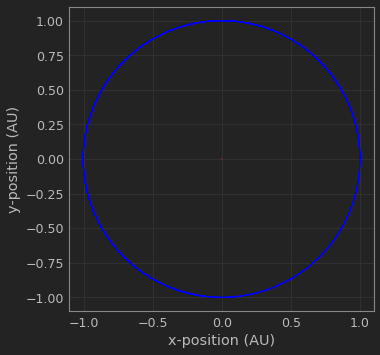

In [7]:
#second plot: traced motions in the x-y plane

#create arrays for y positions for the sun and earth over all times
y_sun = positions_au[:, 0, 1]
y_earth = positions_au[:, 1, 1]

#create a x-position vs. y-position plot
plt.plot(x_sun, y_sun, c='red')
plt.plot(x_earth, y_earth, c='blue')
jtplot.style(theme='monokai')
plt.xlabel('x-position (AU)')
plt.ylabel('y-position (AU)')
plt.axis('scaled');

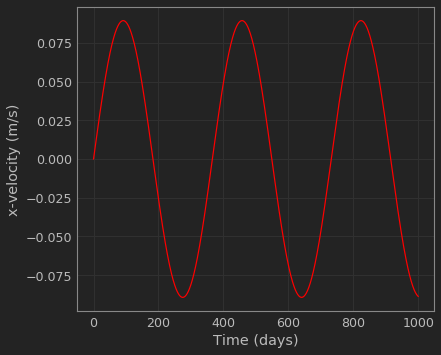

In [32]:
# x-velocity of the sun as a function of time

# create an array for the suns x velocities
Vx_sun = sun_earth_velocities[:, 0, 0]

#create a time vs. x-velocity plot
plt.plot(time_days, Vx_sun, c='red')
jtplot.style(theme='monokai')
plt.xlabel('Time (days)')
plt.ylabel('x-velocity (m/s)');

In [9]:
# step 3: run the same function on the sun earth system except velocity decreased by a factor of 2
sun_earth_2 = calculateTrajectories(np.array([1.989e30,5.972e24]), np.array([[-3e-6, 0 , 0],
                     [0.9999997, 0 , 0]])*au, np.array([[0, -8.92e-2, 0],
                       [0,  2.98e4 , 0]])/2, time_passed, dt)

sun_earth_times2, sun_earth_positions2, sun_earth_velocities2 = sun_earth_2

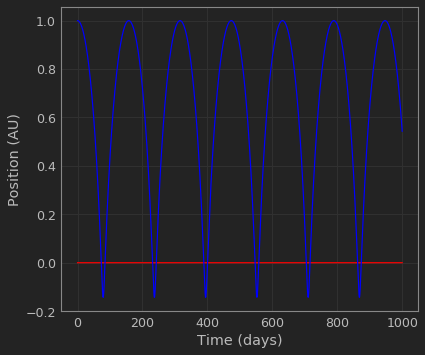

In [10]:
time_days2 = sun_earth_times2 / sec
positions_au2 = sun_earth_positions2 / au

#create two arrays for x positions for the sun and earth over all times
x_sun = positions_au2[:, 0, 0]
x_earth = positions_au2[:, 1, 0]

#create a time vs. x-position plot
plt.plot(time_days2, x_sun, c='red')
plt.plot(time_days2, x_earth, c='blue')
jtplot.style(theme='monokai')
plt.xlabel('Time (days)')
plt.ylabel('Position (AU)');

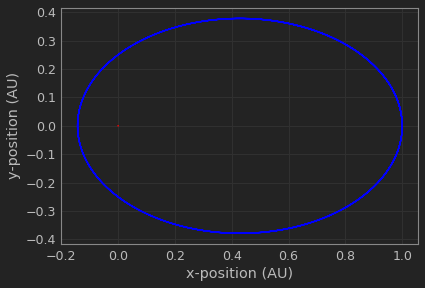

In [11]:
#second plot: traced motions in the x-y plane

# create two arrays for y positions for the sun and earth over all times
y_sun = positions_au2[:, 0, 1]
y_earth = positions_au2[:, 1, 1]

#create a x-position vs. y-position plot
plt.plot(x_sun, y_sun, c='red')
plt.plot(x_earth, y_earth, c='blue')
plt.xlabel('x-position (AU)')
plt.ylabel('y-position (AU)')
plt.axis('scaled');

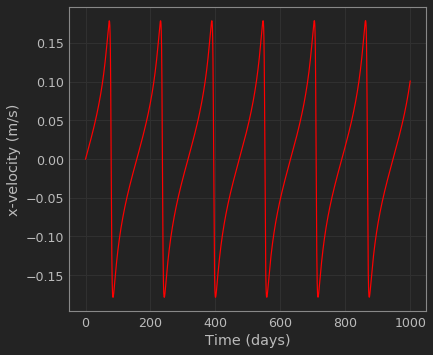

In [12]:
# x-velocity of the sun as a function of time

#create an array of x-velocities for the sun at each time
Vx_sun = sun_earth_velocities2[:, 0, 0]

#create a time vs. x-velocity plot
plt.plot(time_days2, Vx_sun, c='red')
jtplot.style(theme='monokai')
plt.xlabel('Time (days)')
plt.ylabel('x-velocity (m/s)');

# 4: Exoplanet Kepler-16A Bb

In [13]:
# step 1: read in kepler data into arrays that can be used in the calculateTrajectories function

kepler16 = np.loadtxt('kepler16.txt')

masses_kepler = []
positions_kepler = []
velocities_kepler = []

for i in range(len(kepler16)):
    m_kepler = kepler16[i][0]
    
    px_kepler = kepler16[i][1]
    py_kepler = kepler16[i][2]
    pz_kepler = kepler16[i][3]
    pos_kepler = px_kepler,py_kepler,pz_kepler
    
    vx_kepler = kepler16[i][4]
    vy_kepler = kepler16[i][5]
    vz_kepler = kepler16[i][6]
    vel_kepler = vx_kepler,vy_kepler,vz_kepler
    
    masses_kepler.append(m_kepler)
    positions_kepler.append(pos_kepler)
    velocities_kepler.append(vel_kepler)
    
masses_kepler = np.array(masses_kepler)
positions_kepler = np.array(positions_kepler)
velocities_kepler = np.array(velocities_kepler)

In [14]:
print(masses_kepler) # make sure the masses got read in correctly

[1.3718e+30 4.0287e+29 6.3250e+26]


In [15]:
print(positions_kepler) # make sure the positions got read in correctly

[[ 7.6349e+09 -9.6587e+05  1.8447e+09]
 [-2.5998e+10  3.2889e+06 -6.2813e+09]
 [ 3.7761e+10 -4.0923e+07  8.1934e+10]]


In [16]:
print(velocities_kepler) # make sure the velocities got read in correctly

[[-1.0502e+03 -6.8224e+00  1.3030e+04]
 [ 3.5760e+03  2.3231e+01 -4.4368e+04]
 [-3.6298e+04 -1.0812e+01  1.7020e+04]]


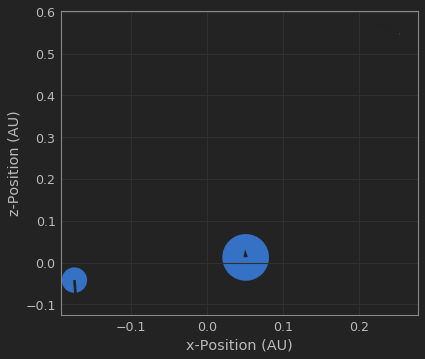

In [17]:
# step 2: plotting x-z plane wvectors representing initial velocities

# convert positions and velocities in terms of AU for graphing purposes, will convert backto SI
# later for the calculateTrajectories function

positions_kepler = positions_kepler/au
velocities_kepler = velocities_kepler/au

#scatter plot the three keplerian bodies with velocity vectrs on each
plt.scatter(positions_kepler[:, 0], positions_kepler[:, 2], 
            s = masses_kepler/np.min(masses_kepler));
plt.quiver(positions_kepler[:, 0], positions_kepler[:, 2], 
           velocities_kepler[:, 0], velocities_kepler[:, 2])
    
# scale the x and y axis limits (with some additional scaling by multiplication to make it look nice)
plt.xlim((np.min(positions_kepler[:, 0])*1.1), (np.max(positions_kepler[:, 0])*1.1))
plt.ylim((np.min(positions_kepler[:, 2])*3.0), (np.max(positions_kepler[:, 2])*1.1))
plt.xlabel('x-Position (AU)')
plt.ylabel('z-Position (AU)');

In [18]:
# change positions and velocities back to being in terms of meters for calculateTrajectories
positions_kepler = positions_kepler*au
velocities_kepler = velocities_kepler*au
kepler_days = 500. * sec
kepler_dt = 0.5 * sec

kepler_motion = calculateTrajectories(masses_kepler,positions_kepler,velocities_kepler, 
                                      kepler_days, kepler_dt)

kepler_times, kepler_positions, kepler_velocities = kepler_motion

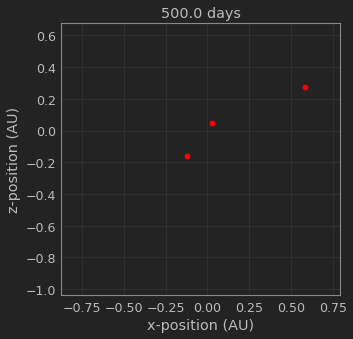

In [19]:
#step 4: making a movie of kepler16 system

import matplotlib.animation as ani
writer = ani.FFMpegWriter(fps=15)
fig = plt.figure(figsize=(5,5))
with writer.saving(fig, 'kepler16.mp4', 100):
    for i in range(len(kepler_times)): 
        plt.cla()
        
        # plot the new x and y values`
        plt.scatter(kepler_positions[i, :, 0]/au, kepler_positions[i, :, 2]/au, color='red')
        
        # set the x and y limits to the minimum and maximum x and y positions +/- a factor of 1.1x 
        #au to keep the points from touching the axes
        plt.xlim((np.min(kepler_positions[:, :, 0])/au)*1.1, 
                 (np.max(kepler_positions[:, :, 0])/au)*1.1)
        plt.ylim((np.min(kepler_positions[:, :, 2])/au)*1.1, 
                 (np.max(kepler_positions[:, :, 2])/au)*1.1)
        
        # give the plot some labels, including a title that tracks the day we are looking at
        plt.title('{} days'.format(kepler_times[i]/sec))
        plt.xlabel('x-position (AU)')
        plt.ylabel('z-position (AU)')
        
        # save the current plot as a movie frame
        writer.grab_frame()

# 5. Create your own adventure - Planetesimal disk

In [20]:
# lets read in the planetesimal data into mass, position, and velocity arrays
planetesimalDisk = np.loadtxt('planetesimalDisk.txt')

masses_planetesimal = []
positions_planetesimal = []
velocities_planetesimal = []

for i in range(len(planetesimalDisk)):
    m_planetesimalDisk = planetesimalDisk[i][0]
    
    px_planetesimalDisk = planetesimalDisk[i][1]
    py_planetesimalDisk = planetesimalDisk[i][2]
    pz_planetesimalDisk = planetesimalDisk[i][3]
    pos_planetesimalDisk = px_planetesimalDisk,py_planetesimalDisk,pz_planetesimalDisk
    
    vx_planetesimalDisk = planetesimalDisk[i][4]
    vy_planetesimalDisk = planetesimalDisk[i][5]
    vz_planetesimalDisk = planetesimalDisk[i][6]
    vel_planetesimalDisk = vx_planetesimalDisk,vy_planetesimalDisk,vz_planetesimalDisk
    
    masses_planetesimal.append(m_planetesimalDisk)
    positions_planetesimal.append(pos_planetesimalDisk)
    velocities_planetesimal.append(vel_planetesimalDisk)
    
masses_planetesimal = np.array(masses_planetesimal)
positions_planetesimal = np.array(positions_planetesimal)
velocities_planetesimal = np.array(velocities_planetesimal)

In [21]:
# Lets simulate the planetesimal disk motion for 365 days
# Lets have it evolve in time steps of 0.5 days
planetesimal_time = 365.*sec
dt = 0.5*sec
planetesimalDisk_motion = calculateTrajectories(masses_planetesimal, positions_planetesimal,
                                               velocities_planetesimal, planetesimal_time, dt)
planetesimal_times, planetesimal_positions, planetesimal_velocities = planetesimalDisk_motion

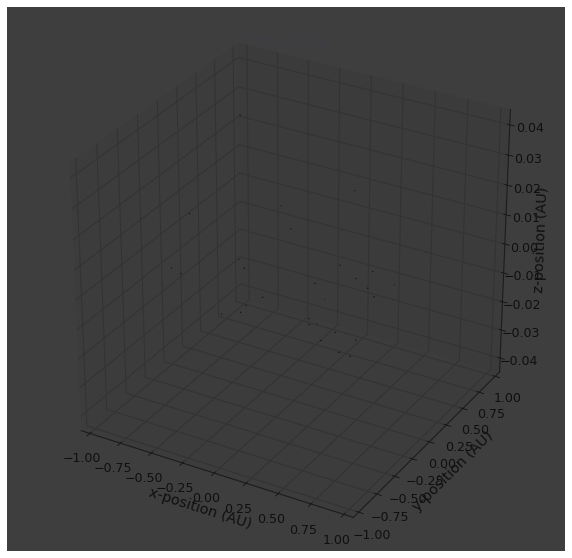

In [34]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
writer = ani.FFMpegWriter(fps=25)
with writer.saving(fig, "planetesimalDisk_3D.mp4", 200):
    for i in range(len(planetesimal_times)):
        plt.cla()
        # plot the new x and y values`
        ax.scatter(planetesimal_positions[i, :, 0]/au, planetesimal_positions[i, :, 1]/au, 
                   planetesimal_positions[i, :, 2]/au, color = 'black',
                   s = masses_planetesimal/np.min(masses_planetesimal))
        
        ax.set_xlim((np.min(planetesimal_positions[:, :, 0])/au*1.1), 
                    (np.max(planetesimal_positions[:, :, 0]))/au*1.1); 
        
        ax.set_ylim((np.min(planetesimal_positions[:, :, 1])/au*1.1), 
                    np.max(planetesimal_positions[:, :, 1])/au*1.1); 
        
        ax.set_zlim((np.min(planetesimal_positions[:, :, 2])/au*1.1), 
                    np.max(planetesimal_positions[:, :, 2])/au*1.1)
        
        jtplot.style(theme='grade3')
        ax.set_xlabel('x-position (AU)')
        ax.set_ylabel('y-position (AU)')
        ax.set_zlabel('z-position (AU)')
        plt.title('{} days'.format(planetesimal_times[i]/sec))
        
        # save the current plot as a movie frame
        writer.grab_frame()
        
# side note: for some reason, the movie keeps fluctuating in brightness, wasn't sure how to fix it